# Задача:

Построить с помощью Python модель компьютерного зрения, способную классифицировать изображения кошек и собак.

Данные:

Вы можете использовать набор данных Dogs vs. Cats, который доступен на Kaggle. Набор данных содержит 25 000 изображений кошек и собак, по 12 500 изображений каждого класса.

Инструкции:

1. Загрузите набор данных "Собаки против кошек".
2. Разделите набор данных на обучающий и тестовый наборы.
3. Предварительно обработайте изображения, изменив их размер до фиксированного и нормализовав значения пикселей.
4. Выберите подходящий алгоритм машинного обучения для классификации изображений.
5. Обучить модель на обучающем множестве.
6. Оценить работу модели на тестовом наборе, используя соответствующие метрики (например, точность).
7. Используйте обученную модель для классификации нового изображения кошки или собаки.
8. Подготовьте графики метрик точности.

Ограничения
Ожидаемая точность на тестовом датасете не ниже 90%.
Модель не должна содержать больше 5 слоёв.

# Вступление
Код писал на Пайторч. Создал MVP (первую модель, преодолевшую отметку 0,9 по метрике accuracy). Графики метрик точности создал на стадии обучения и тестирования. В п. 5 задания для меня была неопределенность. Я решил поступить как правильно: разделил обучающий набор на обучающий и валидационный. В конце ноутбука написал выводы по этой работе.

https://www.kaggle.com/code/ivanshingel/cnn-for-beginners-complete-guide - baseline

# 

In [2]:
import os
import imp
import torch
import random
import torchvision

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR

from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, models

# ml lib
from sklearn.model_selection import train_test_split


/tmp/ipykernel_31/501030874.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
class EarlyStopping:
    """
    Останавливает обучение модели, если валидационная метрика не улучшается в течение заданного числа эпох.
    Параметры:
    ----------
    patience: int, default=7
        Допустимое число эпох без улучшения валидационной метрики.
        Валидационная метрика должна улучшаться как минимум каждые ``patience`` эпох, иначе обучение останавливается.
    mode: str, default="min"
        Режим работы. Допустимые значения: "min", "max" - минимизация или максимизация целевой метрики соответственно.
    verbose: bool, default=False
        Печатать ли сообщение при каждом улучшении валидационной метрики.
    delta: int, default=0
        Минимальное изменение контролируемой метрики, которое можно считать улучшением.
    save_path: str, default="checkpoint.hdf5"
        Путь до файла, в который необходимо сохранять лучшую модель.
    metric_name: str, default=None
        Имя метрики.
    save_format: str, default="torch"
        Формат модели. Допустимые значения: "torch", "tf" - для моделей на фреймворках pytorch и tensorflow.keras соответственно.
    """

    def __init__(self, patience=7, mode='min', verbose=False, delta=0, save_path='checkpoint.hdf5', metric_name=None, save_format='torch'):
        if mode not in ["min", "max"]:
            raise ValueError(f"Unrecognized mode: {mode}! Please choose one of the following modes: \"min\", \"max\"")

        if save_format not in ["torch", "tf"]:
            raise ValueError(f"Unrecognized format: {save_format}! Please choose one of the following formats: \"torch\", \"tf\"")

        self.patience = patience
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_prev_score = np.Inf if mode == "min" else -np.Inf
        self.delta = delta
        self.save_path = save_path
        self.metric_name = "metric" if not metric_name else metric_name
        self.save_format = save_format

    def __call__(self, metric_value, model):

        score = -metric_value if self.mode == "min" else metric_value

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(metric_value, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                f"No imporvement in validation {self.metric_name}. Current: {score:.6f}. Current best: {self.best_score:.6f}")
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(metric_value, model)
            self.counter = 0

    def save_checkpoint(self, metric_value: float, model: torch.nn.Module or tensorflow.keras.Model):
        """
        Cохраняет модель, если валидационная метрика улучшилась.
        Параметры:
        ----------
        metric_value: float
            Значение валидационной метрики.
        model: torch.nn.Module or tensorflow.keras.Model
            Обучаемая модель.
        Возвращаемое значение:
        ----------------------
        None
        """
        if self.verbose:
            print(
                f"Validation {self.metric_name} improved ({self.best_prev_score:.6f} --> {metric_value:.6f}).  Saving model...")
        if self.save_format == "tf":
            model.save_weights(self.save_path)
        else:
            torch.save(model.state_dict(), self.save_path)

        self.best_prev_score = metric_value

In [4]:
# Global vars

SEED = 127
TRAIN_PATH = '../working/train'
TEST_PATH = '../working/test1'
TRAIN_BATCHSIZE = 32
TEST_BATCHSIZE = 128

EPOCHS = 50

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# EDA

In [5]:
# manual_seed
torch.manual_seed(SEED)

In [6]:
os.listdir('../input/dogs-vs-cats/')

['test1.zip', 'train.zip', 'sampleSubmission.csv']

In [7]:
!unzip -q "/kaggle/input/dogs-vs-cats/test1.zip"
!unzip -q "/kaggle/input/dogs-vs-cats/train.zip"

In [8]:
# get labels

labels_list = []
train_imgs = os.listdir('../working/train')

for f in train_imgs:
    
    # 0 for 'cat', 1 for 'dog'
    if f.split('.')[0] == 'cat':
        labels_list.append(0)

    elif f.split('.')[0] == 'dog':
        labels_list.append(1)

    else:
    # if no label 
        labels_list.append(-1)

print(f'Images count = {len(train_imgs)}\nLabels count = {len(labels_list)}')

Images count = 25000
Labels count = 25000


In [9]:
df_train = pd.DataFrame(columns= ['image', 'label'])
df_train['image'] = train_imgs
df_train['label'] = labels_list

df_train.head(3)

,image,label
0,dog.3577.jpg,1
1,dog.6669.jpg,1
2,dog.4668.jpg,1


In [10]:
df_train['label'].unique()

array([1, 0])

Text(0.5, 1.0, 'Count of labels')

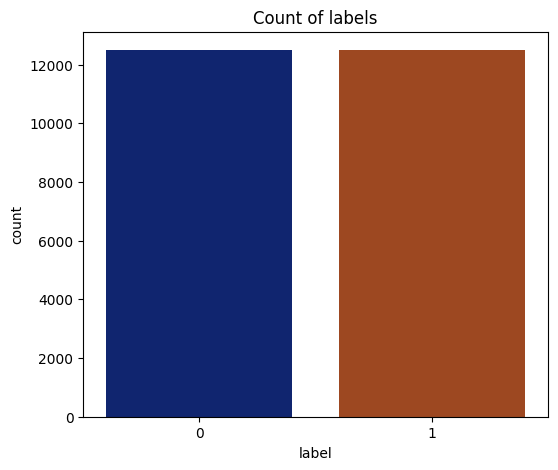

In [11]:
plt.rcParams['figure.figsize'] = (6,5)
ax = sns.countplot(data= df_train, x= 'label', palette= 'dark')
ax.set_title('Count of labels')


In [12]:
shape_arr = []

for i in range(0, df_train.shape[0]):
    img_path = os.path.join(TRAIN_PATH, df_train['image'][i])

    with Image.open(img_path) as img:
        width, height = img.size
        shape_arr.append((width, height))

np.unique(shape_arr, axis= 0).__len__()

8513

In [13]:
np.max(shape_arr, axis= 0)

array([1050,  768])

In [14]:
np.min(shape_arr, axis= 0)

array([42, 32])

Картинки по размеру находятся в большом диапазоне.

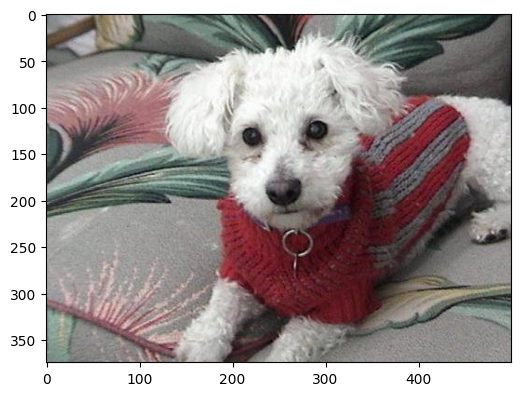

In [15]:
img_path = os.path.join(TRAIN_PATH, df_train['image'][1])

with Image.open(img_path) as img:
    plt.imshow(img)

# Mean and std to reshape and normalize

Расчет этих значений очень долгий, поэтому закомментил код после первого расчета.

## Mean (channels)

r_mean_arr = []
g_mean_arr = []
b_mean_arr = []

for i in range(0, df_train.shape[0]):
    img_path = os.path.join(TRAIN_PATH, df_train['image'][i])
    
    with Image.open(img_path) as img:
        img_np = np.array(img.getdata()).reshape(img.size[0], img.size[1], 3)

        r_mean, g_mean, b_mean = np.mean(img_np, axis= (0,1))

        r_mean_arr.append(r_mean)
        g_mean_arr.append(g_mean)
        b_mean_arr.append(b_mean)


R_MEAN = np.mean(r_mean_arr) / 255
G_MEAN = np.mean(g_mean_arr) / 255
B_MEAN = np.mean(b_mean_arr) / 255

In [16]:
R_MEAN = 0.4883228421888498
G_MEAN = 0.45508163042054794
B_MEAN = 0.41695605716436257

In [17]:
print(f"Red ch mean   = {R_MEAN}\nGreen ch mean = {G_MEAN}\nBlue ch mean  = {B_MEAN}")

Red ch mean   = 0.4883228421888498
Green ch mean = 0.45508163042054794
Blue ch mean  = 0.41695605716436257


## Std (channels)

r_std_arr = []
g_std_arr = []
b_std_arr = []

for i in range(0, df_train.shape[0]):
    img_path = os.path.join(TRAIN_PATH, df_train['image'][i])
    
    with Image.open(img_path) as img:
        img_np = np.array(img.getdata()).reshape(img.size[0], img.size[1], 3)

        r_std, g_std, b_std = np.std(img_np, axis= (0,1))

        r_std_arr.append(r_std)
        g_std_arr.append(g_std)
        b_std_arr.append(b_std)


R_STD = np.mean(r_std_arr) / 255
G_STD = np.mean(g_std_arr) / 255
B_STD = np.mean(b_std_arr) / 255

In [18]:
R_STD = 0.22944326551560382
G_STD = 0.22498400642892036
B_STD = 0.22518627654899104

In [19]:
print(f"Red ch std   = {R_STD}\nGreen ch std = {G_STD}\nBlue ch std  = {B_STD}")

Red ch std   = 0.22944326551560382
Green ch std = 0.22498400642892036
Blue ch std  = 0.22518627654899104


# Train/test/validation split

In [20]:
# Разделил на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(df_train['image'], df_train['label'], 
                                                    test_size= 0.05, random_state= SEED, 
                                                    stratify= df_train['label'])

print(f'Train size = {X_train.shape[0]}\nTest size = {X_test.shape[0]}')

Train size = 23750
Test size = 1250


In [21]:
# Выделил валидационную выборку
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, 
                                                    test_size= 0.13, random_state= SEED, 
                                                    stratify= y_train)

print(f'Train size = {X_train2.shape[0]}\nTest size = {X_val.shape[0]}')

Train size = 20662
Test size = 3088


# stratified check

fig, axs = plt.subplots(1,2, figsize= (15,7))

sns.countplot(x= y_train, ax= axs[0], palette= 'dark')
sns.countplot(x= y_test, ax= axs[1], palette= 'bright')

# Transforms

In [22]:
train_transforms = transforms.Compose(
    [transforms.Resize((128, 128)), # Изменив размер картинок до фиксированного
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(), 
     #transforms.Normalize([R_MEAN, G_MEAN, B_MEAN], [R_STD, G_STD, B_STD])])
     transforms.Normalize(mean= [0.488, 0.455, 0.417], std= [0.229, 0.225, 0.225])]) # Нормализовал значения пикселей.
# Хотя метод transforms.ToTensor() тоже автоматически нормализует пиксели в массивах PIL и numpy.

In [23]:
test_transforms =  transforms.Compose(
    [transforms.Resize((128, 128)),
    transforms.ToTensor(), 
    #transforms.Normalize([R_MEAN, G_MEAN, B_MEAN], [R_STD, G_STD, B_STD])])
    transforms.Normalize(mean= [0.488, 0.455, 0.417], std= [0.229, 0.225, 0.225])])

# Creating train/test/validation datasets and loader

In [24]:
from torch.utils.data import Dataset, DataLoader

In [25]:
class DogsCatsData(Dataset):
    def __init__(self, x, y, transform=None, submission= False):
        self.x = x.reset_index()
        self.y = y.reset_index()
        self.submission = submission
        self.transform = transform
        
    def __len__(self): # переопределил метод len класса Dataset по подсчету кол-ва объектов для DataLoader
        return self.x.shape[0]
    
    def load_image(self, path): # создал новый метод загрузки картинок в классе DogsCatsData
        prefix = TRAIN_PATH
        if self.submission:
            prefix = TEST_PATH
        #return np.array(Image.open(os.path.join(prefix, path)))
        return Image.open(os.path.join(prefix, path['image']))
    
    def __getitem__(self, index): # переопределил метод getitem класса Dataset получения наблюдения по индексу
        image = self.load_image(self.x.iloc[index])
        label = self.y.iloc[index]['label']
        if self.transform:
            image = self.transform(image)
        if self.submission:
            image = np.array(image)
        sample = {'image': image, 'label': label}
        return sample

In [26]:
# Инициализировал DogsCatsData и переложил предобработку картинок в этот класс
train_data = DogsCatsData(X_train, y_train, transform= train_transforms)
test_data = DogsCatsData(X_test, y_test, transform= test_transforms)
train2_data = DogsCatsData(X_train2, y_train2, transform= train_transforms)
val_data = DogsCatsData(X_val, y_val, transform= test_transforms)

In [27]:
# Инициализировал генераторы бачей
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers= 2) #, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, num_workers= 2) #, drop_last = True)
train2_loader = torch.utils.data.DataLoader(train2_data,batch_size=32, num_workers= 2) #, drop_last = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, num_workers= 2) #, drop_last = True)

In [28]:
for i_batch, sample_batched in enumerate(train2_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'].size())
    
    if i_batch > 4:
        break


0 torch.Size([32, 3, 128, 128]) torch.Size([32])
1 torch.Size([32, 3, 128, 128]) torch.Size([32])
2 torch.Size([32, 3, 128, 128]) torch.Size([32])
3 torch.Size([32, 3, 128, 128]) torch.Size([32])
4 torch.Size([32, 3, 128, 128]) torch.Size([32])
5 torch.Size([32, 3, 128, 128]) torch.Size([32])


# CNN model

In [29]:
#import torch.nn as nn

class ConvNet(nn.Module):
    # Реализация модели в виде класса с использованием базовых методов из torch.nn.Module
    def __init__(self):
        super(ConvNet, self).__init__()

        # layer1
        # padding = "same"
        self.cv1 = nn.Conv2d(in_channels= 3, out_channels= 32, kernel_size= 3)
        self.batch_norm1 = nn.BatchNorm2d(num_features= 32)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(2)
        self.max_pool2 = nn.MaxPool2d(2)

        # layer2
        # padding = "same"
        self.cv2 = nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 3)
        self.batch_norm2 = nn.BatchNorm2d(num_features= 64)
        self.relu2 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(2)
        self.max_pool6 = nn.MaxPool2d(2)

        # layer3
        # padding = "same"
        self.cv3 = nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size= 3)
        self.batch_norm3 = nn.BatchNorm2d(num_features= 128)
        self.relu3 = nn.ReLU()
        self.max_pool3 = nn.MaxPool2d(2)
        self.max_pool4 = nn.MaxPool2d(2)
        
        # fc1
        self.fc1 = nn.Linear(128, 300)
        self.relu_fc1 = nn.ReLU()

        # fc3
        self.fc3 = nn.Linear(300, 2)
        #self.sfmx3 = nn.LogSoftmax()


    def forward(self, x):
        # Реализация прямого прохода.
        # layer1
        x = self.max_pool2(self.max_pool1(self.relu1(self.batch_norm1(self.cv1(x)))))

        # layer2
        x = self.max_pool6(self.max_pool5(self.relu2(self.batch_norm2(self.cv2(x)))))

        # layer3
        x = self.max_pool4(self.max_pool3(self.relu3(self.batch_norm3(self.cv3(x)))))

        x = x.view(x.size(0), -1) #  x.size(0) - размер бача, в каждом наблюдении бача перевожу картинку в 1-мерный вид


        # fc 1,3
        x = self.relu_fc1(self.fc1(x))

        x = self.fc3(x)
        #x = self.sfmx3(x)
    
        return x

# Train model

In [43]:
net = ConvNet()

In [31]:
def test_model(model: torch.nn.Module, test_loader: torch.utils.data.DataLoader):
    """
        Проверяет и распечатывает усредненные значения CrossEntropyLoss и accuracy на тестовой выбоке.
        Параметры:
        ----------
        model: torch.nn.Module
            Обучаемая модель.
        test_loader:torch.utils.data.DataLoader 
            Итератор бачей
        Возвращаемое значение:
        ----------------------
        Усредненное значение CrossEntropyLoss и усредненное значение accuracy
    """

    model.eval()
    
    criterion = nn.CrossEntropyLoss()
    acc_list = []
    loss_list = []
    val_loss = 0
    with torch.no_grad():
        for batch_no, data in tqdm(enumerate(test_loader, 0)):
            samples, labels = data['image'], data['label']
            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)
            
            output = model(samples)
            loss = criterion(output, labels)
            
            val_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            acc = acc.to('cpu')
            acc_list.append(acc)
            loss = loss.to('cpu')
            loss_list.append(loss)

    print(f'test Loss = {np.mean(loss_list): .3f}, test accuracy = {np.mean(acc_list): .3f}')
    
    model.train()
    
    print('Finished Testing...')
    
    return np.mean(loss_list), np.mean(acc_list)

In [44]:
max_lr = 0.1
grad_clip = 0.1
weight_decay = 1e-4
#optimizer = optim.Adam(net.parameters(), max_lr, weight_decay=weight_decay)

optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()

In [33]:
train_total_steps = len(train_loader)
print(f'{EPOCHS} epochs, {train_total_steps} total_steps per epoch')

50 epochs, 743 total_steps per epoch


In [34]:
train2_total_steps = len(train2_loader)
print(f'{EPOCHS} epochs, {train2_total_steps} total2_steps per epoch')

50 epochs, 646 total2_steps per epoch


In [35]:
# Learning rate scheduler
print(torch.__version__)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=EPOCHS, 
                                          anneal_strategy='linear',
                                          steps_per_epoch=2*len(train_loader),
                                          )

2.0.0


In [45]:
!rm -rf $"./checkpoints/"
!mkdir $"./checkpoints/"

In [46]:
PATH_TO_CHECKPOINTS = "./checkpoints/"
es = EarlyStopping(patience=9, mode="max", verbose=True, save_path=os.path.join(PATH_TO_CHECKPOINTS, "best_checkpoint.pt"), 
                   metric_name="accuracy", save_format="torch")

In [39]:
def train_cycle(model: torch.nn.Module,
                train_loader: torch.utils.data.DataLoader,
                test_loader: torch.utils.data.DataLoader,
                optimizer: torch.optim, 
                criterion: torch.nn, 
                p_iter: int, 
                n_epochs: int, 
                scheduler = None, 
                early_stop = None):
    """
        Обучает модель и распечатывает усредненные по количеству итераций значения 
        Loss и accuracy на тренировочной и тестовой выбоке.
        Распечатывает график изменения train_accuracy и test_accuracy по эпохам.
        Параметры:
        ----------
        model: torch.nn.Module
            Обучаемая модель.
        train_loader:torch.utils.data.DataLoader 
            Тренировочный итератор бачей.
        test_loader:torch.utils.data.DataLoader 
            Тестовый итератор бачей.
        optimizer: torch.optim
            Алгоритм оптимизации.
        criterion: torch.nn
            Функция потерь.
        p_iter: int
            Количество итераций между оценками обучения и валидации.
        n_epochs: int
            Количество эпох обучения.
        scheduler = None
            Каллбэк для изменения значения шага обучения во времени.
        early_stop = None
            Каллбэк ранней остановки обучения и сохранения лучшей модели по валидационной метрике качества.
        Возвращаемое значение:
        ----------------------
        None
    """
    model.train()
    model.to(DEVICE)
    itr = 1 # счетчик числа итераций на одной эпохе обучения
    total_loss = 0 # счетчик накопленного лосса на кол-ве p_iter итераций
    train_loss_list = [] # массив накопленных значений лосса на тренировочных данных с интервалом p_iter итераций
    train_acc_list = [] # массив накопленных значений метрики accuracy на тренировочных данных с интервалом p_iter итераций
    test_loss_list = [] # массив накопленных значений лосса на тестовых данных с интервалом p_iter итераций
    test_acc_list = [] # массив накопленных значений метрики accuracy на тестовых данных с интервалом p_iter итераций

    for epoch in range(n_epochs):
        for batch_no, data in enumerate(train_loader, 0): # шаг обучения на одном баче

            samples, labels = data['image'], data['label']
            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            output = model(samples)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
            total_loss += loss.item()

            if itr%p_iter == 0: # проверка качества обучения через кол-во итераций == p_iter
                pred = torch.argmax(output, dim=1)
                correct = pred.eq(labels)
                acc = torch.mean(correct.float())
                acc = acc.to('cpu')
                print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, n_epochs, itr, total_loss/p_iter, acc))
                train_loss_list.append(total_loss/p_iter)
                train_acc_list.append(acc)
                total_loss = 0
               
                test_loss, test_acc = test_model(model, test_loader)
                #test_loss, test_acc = test_loss.to("cpu"), test_acc.to("cpu")
                test_loss_list.append(test_loss)
                test_acc_list.append(test_acc)
                #print(f"[Epoch {epoch+1}/{n_epochs}] Iteration {itr} -> test_Loss: {test_loss}, test_Accuracy: {test_acc}")

            itr += 1
            
        itr = 1
        test_itr = 1
        
        if early_stop:
            early_stop(test_acc, model)
            if early_stop.early_stop:
                print("Early stopping reached. Stop training...")
                break
            torch.save(model.state_dict(), os.path.join(PATH_TO_CHECKPOINTS, 
                                        f"epoch_{EPOCHS+1}_val_{test_acc}.pt"))

    plt.plot(train_acc_list[1:], label='train_accuracy')
    plt.plot(test_acc_list[1:], label='test_accuracy')
    plt.legend()
    plt.title('training and validation accuracy')
    plt.show()
    
    
    print('Finished Training')

[Epoch 1/50] Iteration 646 -> Train Loss: 0.4800, Accuracy: 0.727


97it [00:07, 13.55it/s]


test Loss =  0.392, test accuracy =  0.826
Finished Testing...
Validation accuracy improved (-inf --> 0.826031).  Saving model...
[Epoch 2/50] Iteration 646 -> Train Loss: 0.3344, Accuracy: 0.818


97it [00:07, 13.62it/s]


test Loss =  0.390, test accuracy =  0.825
Finished Testing...
No imporvement in validation accuracy. Current: 0.824742. Current best: 0.826031
EarlyStopping counter: 1 out of 9
[Epoch 3/50] Iteration 646 -> Train Loss: 0.2795, Accuracy: 0.773


97it [00:07, 13.61it/s]


test Loss =  0.286, test accuracy =  0.877
Finished Testing...
Validation accuracy improved (0.826031 --> 0.877255).  Saving model...
[Epoch 4/50] Iteration 646 -> Train Loss: 0.2439, Accuracy: 0.909


97it [00:07, 12.23it/s]


test Loss =  0.285, test accuracy =  0.875
Finished Testing...
No imporvement in validation accuracy. Current: 0.875000. Current best: 0.877255
EarlyStopping counter: 1 out of 9
[Epoch 5/50] Iteration 646 -> Train Loss: 0.2215, Accuracy: 0.909


97it [00:07, 13.76it/s]


test Loss =  0.271, test accuracy =  0.882
Finished Testing...
Validation accuracy improved (0.877255 --> 0.882410).  Saving model...
[Epoch 6/50] Iteration 646 -> Train Loss: 0.1938, Accuracy: 0.864


97it [00:07, 13.63it/s]


test Loss =  0.497, test accuracy =  0.792
Finished Testing...
No imporvement in validation accuracy. Current: 0.791881. Current best: 0.882410
EarlyStopping counter: 1 out of 9
[Epoch 7/50] Iteration 646 -> Train Loss: 0.1725, Accuracy: 0.864


97it [00:07, 13.29it/s]

test Loss =  0.247, test accuracy =  0.896
Finished Testing...
Validation accuracy improved (0.882410 --> 0.895941).  Saving model...


[Epoch 8/50] Iteration 646 -> Train Loss: 0.1542, Accuracy: 0.909


97it [00:07, 13.29it/s]


test Loss =  0.272, test accuracy =  0.882
Finished Testing...
No imporvement in validation accuracy. Current: 0.882410. Current best: 0.895941
EarlyStopping counter: 1 out of 9
[Epoch 9/50] Iteration 646 -> Train Loss: 0.1442, Accuracy: 0.955


97it [00:07, 12.31it/s]


test Loss =  0.370, test accuracy =  0.858
Finished Testing...
No imporvement in validation accuracy. Current: 0.857603. Current best: 0.895941
EarlyStopping counter: 2 out of 9
[Epoch 10/50] Iteration 646 -> Train Loss: 0.1260, Accuracy: 0.909


97it [00:07, 13.74it/s]

test Loss =  0.361, test accuracy =  0.866
Finished Testing...
No imporvement in validation accuracy. Current: 0.866302. Current best: 0.895941
EarlyStopping counter: 3 out of 9


[Epoch 11/50] Iteration 646 -> Train Loss: 0.1174, Accuracy: 0.955


97it [00:07, 13.77it/s]

test Loss =  0.781, test accuracy =  0.788
Finished Testing...
No imporvement in validation accuracy. Current: 0.788338. Current best: 0.895941
EarlyStopping counter: 4 out of 9


[Epoch 12/50] Iteration 646 -> Train Loss: 0.1147, Accuracy: 0.955


97it [00:07, 13.44it/s]


test Loss =  0.254, test accuracy =  0.900
Finished Testing...
Validation accuracy improved (0.895941 --> 0.900451).  Saving model...
[Epoch 13/50] Iteration 646 -> Train Loss: 0.0957, Accuracy: 1.000


97it [00:07, 13.67it/s]

test Loss =  0.297, test accuracy =  0.886
Finished Testing...
No imporvement in validation accuracy. Current: 0.886276. Current best: 0.900451
EarlyStopping counter: 1 out of 9


[Epoch 14/50] Iteration 646 -> Train Loss: 0.0912, Accuracy: 0.955


97it [00:07, 12.59it/s]

test Loss =  0.295, test accuracy =  0.898
Finished Testing...
No imporvement in validation accuracy. Current: 0.897874. Current best: 0.900451
EarlyStopping counter: 2 out of 9


[Epoch 15/50] Iteration 646 -> Train Loss: 0.0871, Accuracy: 0.955


97it [00:07, 13.60it/s]

test Loss =  0.401, test accuracy =  0.866
Finished Testing...
No imporvement in validation accuracy. Current: 0.865657. Current best: 0.900451
EarlyStopping counter: 3 out of 9


[Epoch 16/50] Iteration 646 -> Train Loss: 0.0866, Accuracy: 0.909


97it [00:06, 14.05it/s]

test Loss =  0.372, test accuracy =  0.870
Finished Testing...
No imporvement in validation accuracy. Current: 0.869845. Current best: 0.900451
EarlyStopping counter: 4 out of 9


[Epoch 17/50] Iteration 646 -> Train Loss: 0.0762, Accuracy: 1.000


97it [00:07, 13.85it/s]

test Loss =  0.546, test accuracy =  0.841
Finished Testing...
No imporvement in validation accuracy. Current: 0.841173. Current best: 0.900451
EarlyStopping counter: 5 out of 9


[Epoch 18/50] Iteration 646 -> Train Loss: 0.0703, Accuracy: 1.000


97it [00:07, 13.76it/s]

test Loss =  0.475, test accuracy =  0.855
Finished Testing...
No imporvement in validation accuracy. Current: 0.855348. Current best: 0.900451
EarlyStopping counter: 6 out of 9


[Epoch 19/50] Iteration 646 -> Train Loss: 0.0666, Accuracy: 1.000


97it [00:07, 12.58it/s]

test Loss =  0.565, test accuracy =  0.846
Finished Testing...
No imporvement in validation accuracy. Current: 0.846327. Current best: 0.900451
EarlyStopping counter: 7 out of 9


[Epoch 20/50] Iteration 646 -> Train Loss: 0.0631, Accuracy: 1.000


97it [00:07, 13.76it/s]


test Loss =  0.552, test accuracy =  0.839
Finished Testing...
No imporvement in validation accuracy. Current: 0.838918. Current best: 0.900451
EarlyStopping counter: 8 out of 9
[Epoch 21/50] Iteration 646 -> Train Loss: 0.0558, Accuracy: 0.955


97it [00:07, 13.46it/s]


test Loss =  1.589, test accuracy =  0.710
Finished Testing...
No imporvement in validation accuracy. Current: 0.710052. Current best: 0.900451
EarlyStopping counter: 9 out of 9
Early stopping reached. Stop training...


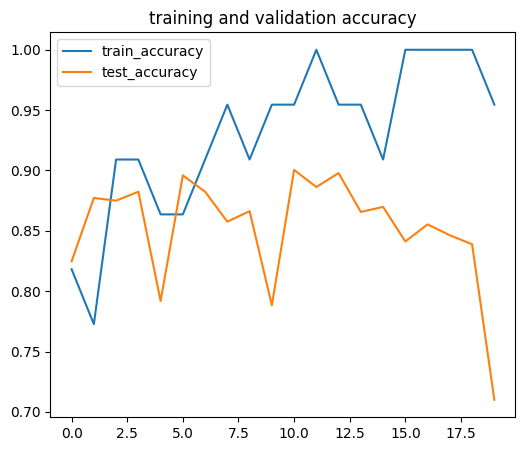

Finished Training


In [47]:
# Тренировка модели
#%%time

train_cycle(net,
            train2_loader,
            val_loader,
            optimizer, 
            criterion, 
            p_iter=646,  
            n_epochs=EPOCHS, 
            scheduler=None,
            early_stop = es)

In [48]:
best_model = ConvNet()

best_model.load_state_dict(torch.load(os.path.join(PATH_TO_CHECKPOINTS, 
                                                   "best_checkpoint.pt")))
best_model.eval().to(DEVICE)

ConvNet(
  (cv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (max_pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (max_pool6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (max_pool4): Max

# Inference model

In [50]:
def test_final_model(model: torch.nn.Module, test_data: torch.utils.data.DataLoader):
    """
    Проверяет и распечатывает усредненные значения CrossEntropyLoss и accuracy на тестовой выбоке.
    Распечатывает график изменения CrossEntropyLoss и accuracy по бачам.
    Параметры:
    ----------
    model: torch.nn.Module
        Обучаемая модель.
    test_loader:torch.utils.data.DataLoader 
        Итератор бачей
    Возвращаемое значение:
    ----------------------
    Усредненное значение CrossEntropyLoss и усредненное значение accuracy
    """
    model.eval()
    
    criterion = nn.CrossEntropyLoss()
    acc_list = []
    loss_list = []
    val_loss = 0
    with torch.no_grad():
        for batch_no, data in tqdm(enumerate(test_data, 0)):
            samples, labels = data['image'], data['label']
            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)
            
            output = model(samples)
            loss = criterion(output, labels)
            
            val_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            acc = acc.to('cpu')
            acc_list.append(acc)
            loss = loss.to('cpu')
            loss_list.append(loss)

    print(f'Mean acc = {np.mean(acc_list): .3f}. Mean loss = {np.mean(loss_list): .3f}')

    plt.plot(loss_list[1:], label='loss')
    plt.plot(acc_list[1:], label='accuracy')
    plt.legend()
    plt.title('testing loss and accuracy')
    plt.show()
    
    model.train()
    
    print('Finished Testing...')
    
    return round(np.mean(loss_list), 3), round(np.mean(acc_list), 3)
            

%%time
#print('Self-made ConvNet:')
test_final_model(net_final, test_loader)

40it [00:02, 14.10it/s]


Mean acc =  0.914. Mean loss =  0.227


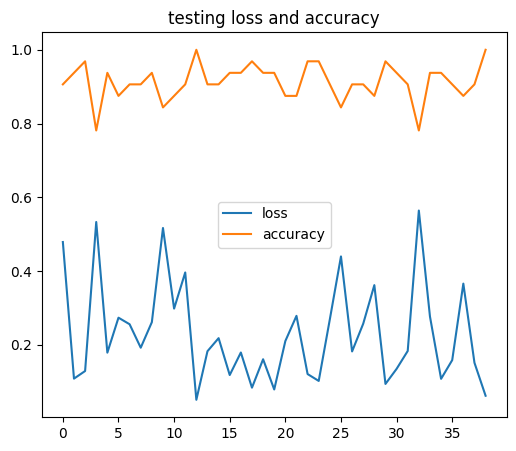

Finished Testing...


(0.227, 0.914)

In [51]:
test_final_model(best_model, test_loader)

# Visualize predictions

In [56]:
sample = next(iter(test_loader))

In [57]:
sample['image'][:5]

tensor([[[[ 1.7734,  1.7906,  1.8248,  ...,  1.7049,  1.7049,  1.7563],
          [ 1.7392,  1.8077,  1.8077,  ...,  1.7221,  1.7049,  1.7221],
          [ 1.6878,  1.8077,  1.8419,  ...,  1.7563,  1.7221,  1.7392],
          ...,
          [ 1.9789,  1.9961,  1.9961,  ...,  2.0474,  2.0132,  2.0303],
          [ 2.0303,  2.0817,  2.0817,  ...,  1.9961,  1.9961,  1.9104],
          [ 2.0303,  2.0817,  2.0817,  ...,  2.0474,  1.9447,  1.8419]],

         [[-0.5930, -0.5756, -0.5407,  ..., -0.1922, -0.1922, -0.1399],
          [-0.6279, -0.5582, -0.5582,  ..., -0.1922, -0.2096, -0.1922],
          [-0.6802, -0.5582, -0.5233,  ..., -0.1922, -0.1922, -0.1747],
          ...,
          [-0.5233, -0.5059, -0.5059,  ..., -0.3664, -0.3839, -0.3664],
          [-0.5059, -0.4536, -0.4536,  ..., -0.3664, -0.4013, -0.4885],
          [-0.5059, -0.4536, -0.4536,  ..., -0.3142, -0.4536, -0.5582]],

         [[ 0.2207,  0.2382,  0.2730,  ...,  0.3776,  0.3427,  0.3950],
          [ 0.1859,  0.2556,  

In [63]:
sample['label'][:10]

tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 0])

In [64]:
outputs = best_model(sample['image'][:10].to(DEVICE))


In [65]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([0, 1, 1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')

In [70]:
classes = ('cat', 'dog')

GroundTruth:  cat dog dog dog dog cat cat cat dog cat


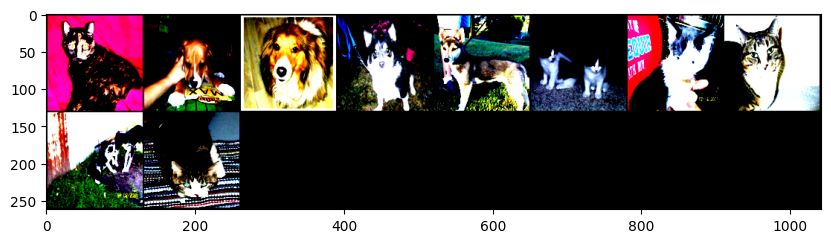

In [71]:
imgs = torchvision.utils.make_grid(sample['image'][:10])
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[sample['label'][j]] for j in range(len(sample['label'][:10]))))

In [73]:
print('Predicted: ', ' '.join(classes[predicted[j]] for j in range(len(sample['label'][:10]))))

Predicted:  cat dog dog cat dog cat cat cat dog cat


In [74]:
# test_loader модель на обучении не видела, поэтому такое тестирование корректно.
gt = np.array([classes[sample['label'][j]] for j in range(len(sample['label'][:10]))])
pred = np.array([classes[predicted[j]] for j in range(len(sample['label'][:10]))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'dog' 'dog' 'dog' 'dog' 'cat' 'cat' 'cat' 'dog' 'cat']
['cat' 'dog' 'dog' 'cat' 'dog' 'cat' 'cat' 'cat' 'dog' 'cat']
Accuracy is 0.9


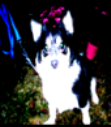

Чтобы понять, что на этом фото собака, мне самому надо долго приглядываться. Здесь только  череп вытянут как у собаки. на седьмой картинке вообще не понятно что, но модель отгадала.

# Выводы
В первом приближении удалось создать модель, перешагнувшую порог в 0,9 accuracy на тестовом наборе данных не смотря на переобучение. Далее для увеличения целевой метрики с ней можно много чего сделать, в первую очередь поработать с инициализацией весов и аугментацией. Но сначала надо убедиться что это самая оптимальная архитектура сетки.
 Надеюсь, что в задании №7 "Используйте обученную модель для классификации нового изображения кошки или собаки." я выполнил задание, взяв изображения из тестового набора, которые модель не видела на стадии обучения. Если нет, то могу доделать решение с картинками из интернета. Или можно посмотреть как я выполнил такую работу в конце этого ноутбука:
 
 https://github.com/DAYa66/Gesture_Recognition_Pytorch/blob/main/Gesture_Recognition_Pytorch.ipynb
 
    Ну и на таком небольшом наборе данных для оценки качества модели напрашивается кроссвалидация с "out of fold" прогнозом.